# Preprocessing Images for OCR

## 00. Opening an Image

In [4]:
import cv2
from matplotlib import pyplot as plt

image_file = "./data/page_01.jpg"
img = cv2.imread(image_file)
print("Image read into memory.")

Image read into memory.


In [5]:
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

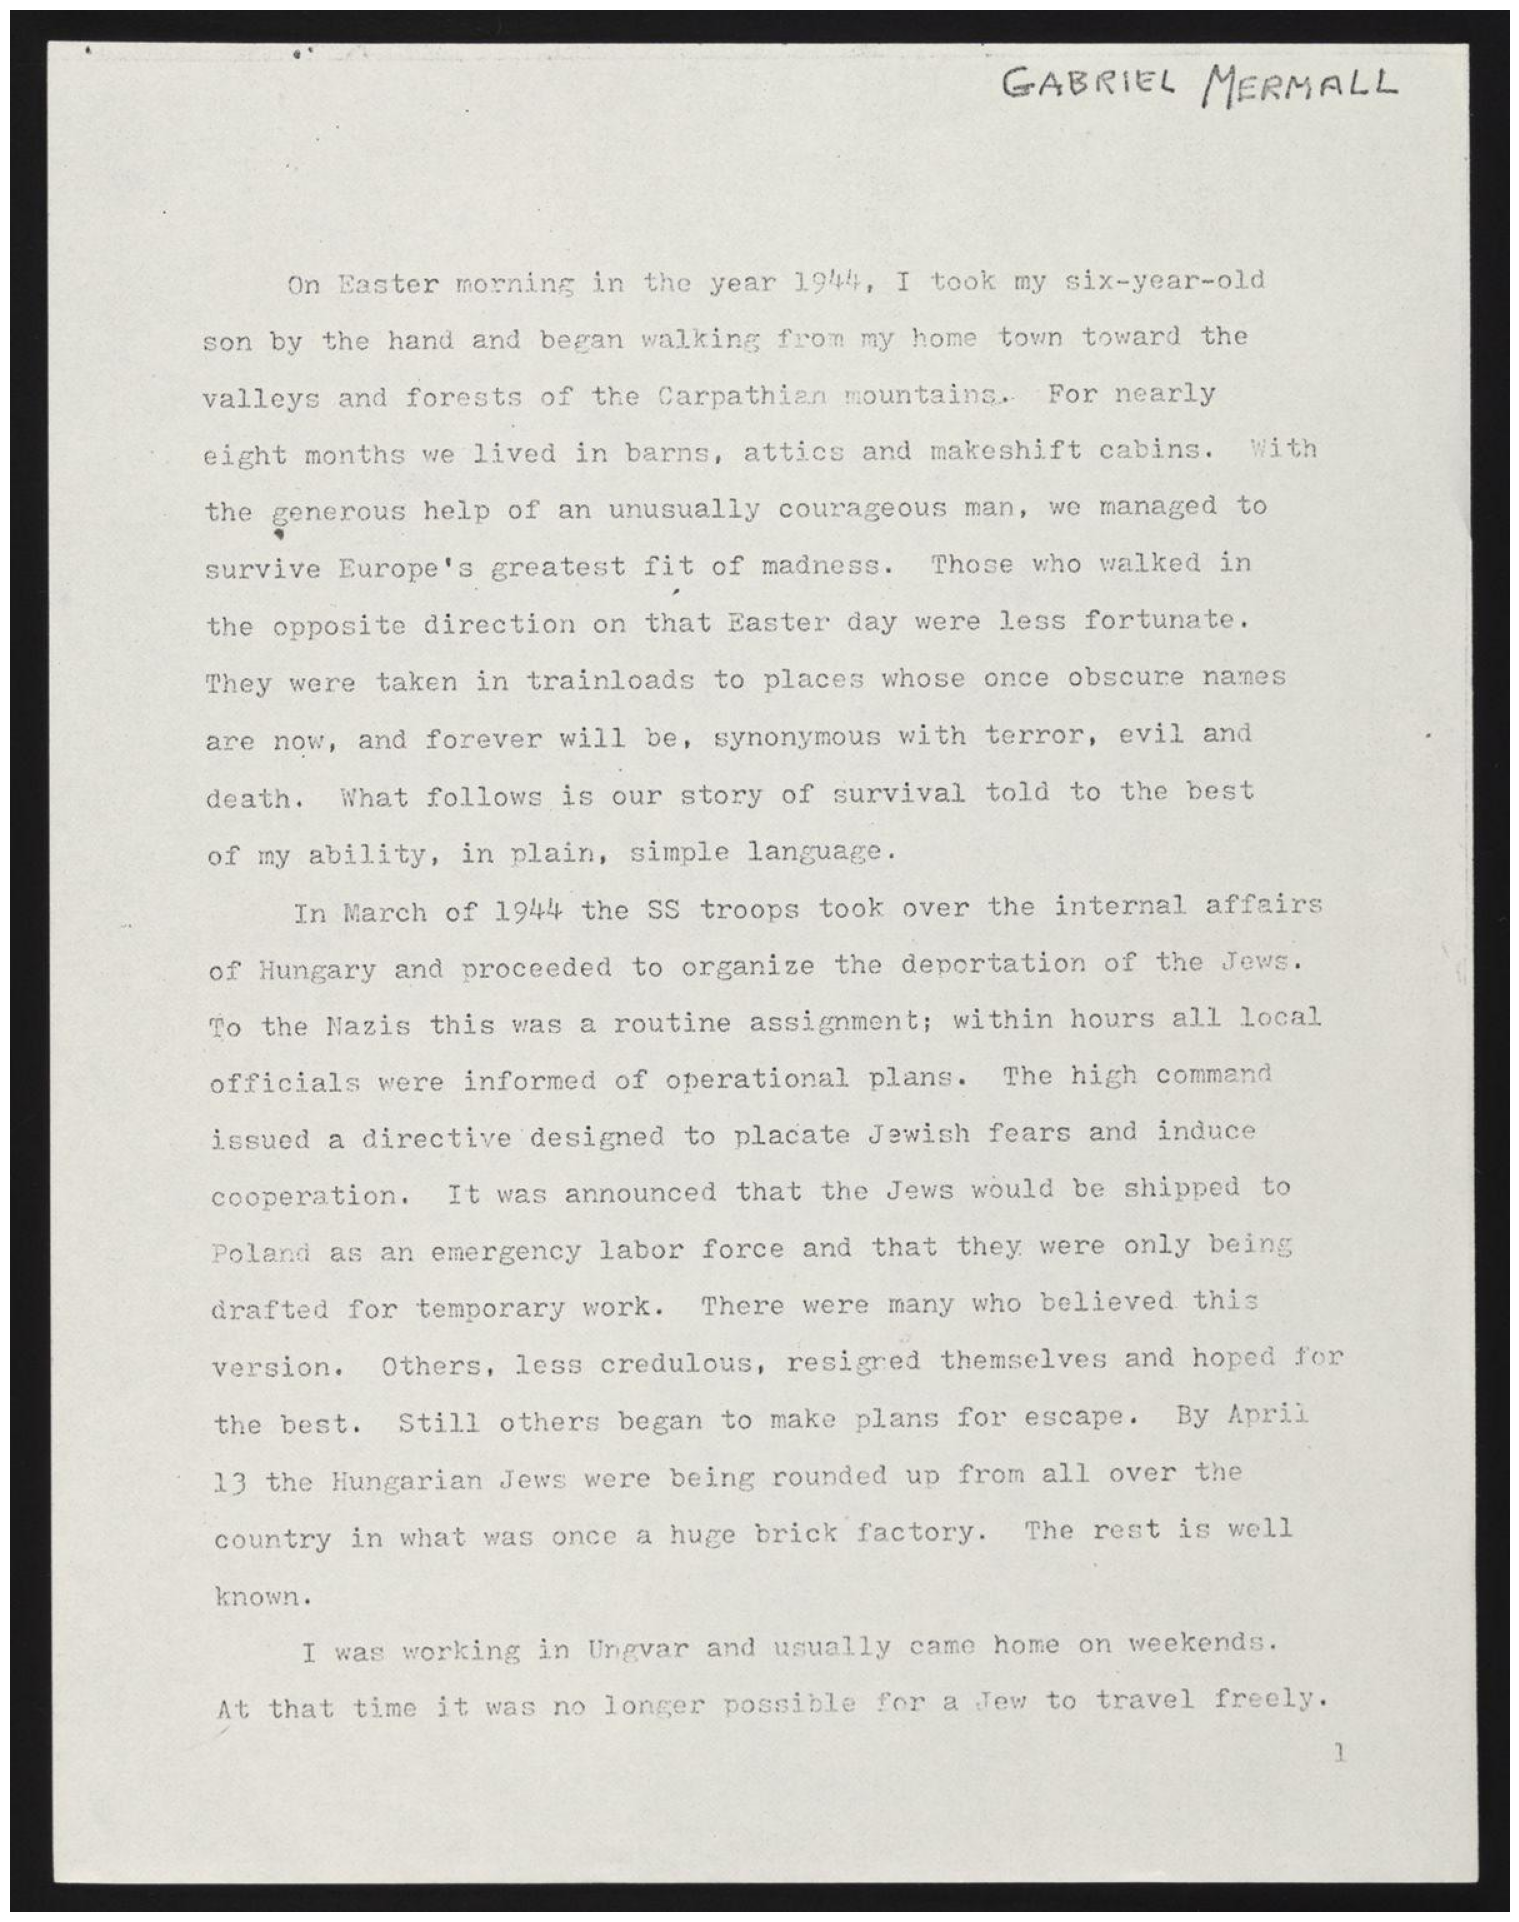

In [6]:
display(image_file)

## 01. Inverted Images

## 02. Rescaling

## 03. Binarization